# Workflow

En esta práctica vamos a aplicar lo aprendido en esta asignatura para crear un flujo que automatice la descarga, análisis y publicación de los datos utilizando distintas herramientas como Zenodo, GitHub y librerías de Python para el análisis de datos.

### Librerías necesarias para la práctica

```python
import xml.etree.ElementTree as ET
import requests
import json
import zipfile
```

### Elementos necesarios
* Al menos un fichero CSV
* Un script de análisis de datos en CSV (Publicado en GitHub)

In [2]:
import xml.etree.ElementTree as ET
import requests
import json
import zipfile

# Publicación de datos iniciales

Utilizando Zenodo, de forma manual, publicar los datos que se vayan a utilizar.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Utilizar Communities para localizar más facilmente los datos</p>
</div>


Tomamos datos de Eurostat sobre tasas de empleo empleo en Europa.  
La tabla actualizada se puede encontrar navegando por el árbol de datos de la [web de Eurostat](https://ec.europa.eu/eurostat/data/database):
```   
   Data navigation tree
     Database by themes
       Population and social conditions
         Labour market(labour)
           Employment and unemployment(Labour force survey)(employ)
             LFS series - detailed quarterly survey results(from 1998 onwards)(lfsq)
               Employment rates - LFS series(lfsq_emprt)
                 Employment rates by sex, age and educational attainment level (%) (lfsq_ergaed)
```

Los datos se presentan agrupados por cuatrimestre y país, y están agregados por sexo, edad y nivel de educación:
- **Países:** BE, BG, CZ, DK, DE, EE, IE, EL, ES, FR, HR, IT, CY, LV, LT, LU, HU, MT, NL, AT, PL, PT, RO, SI, SK, FI, SE, UK, IS, NO, CH, ME, MK, RS, TR. Grupos de países: EU28, EU27, EU15, EA19, EA18, EA17.

- **Sexo:** Female, male.
- **Edad:** Todos los posibles intervalos de edad $[a, b]$ con $a\in \{15, 19, 24, 39, 59, 64\}$ y $b\in \{19, 24, 39, 59, 64, 74\}$.
- **Nivel de educación:** 
  - TOTAL: All ISCED 2011 levels.
  - ED0-2: Less than primary, primary and lower secondary education (levels 0-2).
  - ED3_4: Upper secondary and post-secondary non-tertiary education (levels 3 and 4).
  - ED5-8: Tertiary education (levels 5-8).
  - NRP: No response.
  
Descargamos la tabla (que incluye desde el primer cuatrimestre de 1998 hasta el tercer cuatrimestre de 2018), y la subimos a la comunidad de Zenodo [iipr's Datasets for Data Science](https://zenodo.org/communities/iipr_dlc_unican/). El DOI asignado es https://doi.org/10.5281/zenodo.2541848

# Publicación de script de análisis

En GitHub + Zenodo

Creamos un repositorio público en GitHub https://github.com/iipr-Master-Data-Science/dlc_zenodo_integration  
En él, añadimos un script de Python que toma datos de una tabla del estilo de la que acabamos de describir y genera, para ciertos países, y un cierto rango de edad, dos histogramas horizontales enfrentados que compara los datos correspondientes para mujeres y hombres, agrupando los cuatrimestres en años.

Integramos este repositorio con Zenodo para que cada nueva release se publique automáticamente en Zenodo con su correspondiente DOI. La última está en https://zenodo.org/record/2554373

**Nota:** Ya que el respositorio que he usado no se encuentra en mi cuenta pública de GitHub si no en un organización creada por mi, tuve que dar permiso a Zenodo de manera manual para que pudiera acceder a la información de esta organización y así ver los repositorios contenidos en ella.

# Descarga de datos

Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)

Pista: url+'?verb=ListRecords&set=nombre_set

https://zenodo.org/record/2541848

## Get metadata formats:

In [1]:
def get_oai_metadata_formats(url):
    """Lists the available metadata formats.
        Parameters
        ----------
        url : string
            OAI-PMH endpoint url
        Returns
        -------
        metadata_formats : 
            Name of the downloaded file(s).
    """
    metadata_formats = []
    oai_verb = '?verb=ListMetadataFormats'
    oai = requests.get(url + oai_verb) #Peticion al servidor
    xmlTree = ET.ElementTree(ET.fromstring(oai.text))
    iterator = xmlTree.iter()
    for elem in iterator:
        if (elem.tag == '{http://www.openarchives.org/OAI/2.0/}metadataPrefix'):
            metadata_formats.append(elem.text)
    return metadata_formats

In [3]:
oai_url = 'https://zenodo.org/oai2d'
get_oai_metadata_formats(oai_url)

['marcxml',
 'oai_dc',
 'oai_datacite',
 'marc21',
 'datacite',
 'datacite3',
 'datacite4',
 'oai_datacite3']

## Search dataset

In [28]:
def search_dataset(url, oai_set, metadata_format):
    """Search the datasets identifiers in the defined set.
        Parameters
        ----------
        url : string
            OAI-PMH endpoint url
        oai_set : string
            OAI-PMH set where the datasets will be searched
        metadata_format : string
            Selected metadata format to search
        Returns
        -------
        dataset_ids : array 
            Dataset IDs
    """
    #Define bounds to search in specific set
    bounds = "&set=" + oai_set
    oai = requests.get(url + '?verb=ListRecords' + bounds + '&metadataPrefix=' + metadata_format)
    namespaces = {'oai': 'http://www.openarchives.org/OAI/2.0/'}
    xmlTree = ET.fromstring(oai.text)
    item = xmlTree.findall('.//oai:identifier', namespaces)
    return item

In [82]:
# Para encontrar el dataset, usamos la comunidad creada
oai_set = 'user-iipr_dlc_unican'
id_list = search_dataset(oai_url, oai_set,'oai_dc')
id_list[0].text

'oai:zenodo.org:2541848'

## Get record

In [64]:
def get_records(ids, fnames):
    """Download list of resources.
        Parameters
        ----------
        ids : array
            List of dataset ids
        fnames : array
            List of output file names
    """
    headers = {'accept': 'application/json'}
    for i, id_curr in enumerate(ids):
        id_curr = id_curr.text.split(':')[-1]
        r = requests.get('https://zenodo.org/api/records/{}'.format(id_curr), headers)
        record = json.loads(r.text)
        data_url = record['files'][0]['links']['self']
        with open(fnames[i], 'wb') as f:
            f.write(requests.get(data_url).content)
            print('Data saved in {}'.format(fnames[i]))
    return

In [65]:
fnames = ['lfsq_ergaed.tsv.gz']
get_records(id_list[0:1], fnames)

Data saved in lfsq_ergaed.tsv.gz


También descomprimimos:

In [73]:
!gunzip lfsq_ergaed.tsv.gz

In [74]:
!ls -la

total 15880
drwxr-xr-x  12 iker  staff      408 31 ene 21:03 .
drwxr-xr-x  11 iker  staff      374 31 ene 19:39 ..
-rw-r--r--@  1 iker  staff     6148 31 ene 21:03 .DS_Store
drwxr-xr-x  14 iker  staff      476 31 ene 18:23 .git
-rw-r--r--   1 iker  staff     1976 17 ene 11:43 .gitignore
drwxr-xr-x   4 iker  staff      136 31 ene 18:21 .ipynb_checkpoints
-rw-r--r--   1 iker  staff    58726 31 ene 21:02 M3.02Workflow.ipynb
-rw-r--r--@  1 iker  staff    92962 31 ene 18:21 M3.02Workflow_resuelto.ipynb
-rw-r--r--   1 iker  staff       18 17 ene 11:43 README.md
-rw-r--r--   1 iker  staff    50932 31 ene 21:02 dlc_zenodo_integration-v1.0.zip
drwxr-xr-x   7 iker  staff      238 31 ene 19:50 iipr-Master-Data-Science-dlc_zenodo_integration-1740440
-rw-r--r--   1 iker  staff  7901493 31 ene 20:50 lfsq_ergaed.tsv


# Descarga de código

Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Zenodo guarda un zip con el código</p>
</div>

- Repositorio: https://github.com/iipr-Master-Data-Science/dlc_zenodo_integration/
- Release en Zenodo: http://doi.org/10.5281/zenodo.2554373

Get Record:

In [68]:
verb = '?verb=GetRecord'
comm = '&metadataPrefix=oai_dc&identifier=oai:zenodo.org:2554373'
oai = requests.get(oai_url + verb + comm)
xmlTree = ET.fromstring(oai.text)
iterator = xmlTree.iter()
for elem in iterator:
    print(elem.tag + ': ' + elem.text)

{http://www.openarchives.org/OAI/2.0/}OAI-PMH: 
  
{http://www.openarchives.org/OAI/2.0/}responseDate: 2019-01-31T19:57:53Z
{http://www.openarchives.org/OAI/2.0/}request: https://zenodo.org/oai2d
{http://www.openarchives.org/OAI/2.0/}GetRecord: 
    
{http://www.openarchives.org/OAI/2.0/}record: 
      
{http://www.openarchives.org/OAI/2.0/}header: 
        
{http://www.openarchives.org/OAI/2.0/}identifier: oai:zenodo.org:2554373
{http://www.openarchives.org/OAI/2.0/}datestamp: 2019-01-31T18:52:41Z
{http://www.openarchives.org/OAI/2.0/}metadata: 
        
{http://www.openarchives.org/OAI/2.0/oai_dc/}dc: 
          
{http://purl.org/dc/elements/1.1/}creator: Ignacio Iker Prado Rujas
{http://purl.org/dc/elements/1.1/}date: 2019-01-31
{http://purl.org/dc/elements/1.1/}description: In this new release we have improved the code, allowing to call the script with several arguments:

arg1: TSV file where to get data from.
arg2: Code of the first country to use.
arg3: Code of the second country

In [85]:
# Para encontrar el dataset, usamos la comunidad creada
oai_set = 'user-iipr_dlc_unican'
id_list = search_dataset(oai_url, oai_set,'oai_dc')
id_list[1].text

'oai:zenodo.org:2554373'

In [71]:
fnames = ['dlc_zenodo_integration-v1.0.zip']
get_records(id_list[1:2], fnames)

Data saved in dlc_zenodo_integration-v1.0.zip


Decomprimimos:

In [72]:
!unzip dlc_zenodo_integration-v1.0.zip

Archive:  dlc_zenodo_integration-v1.0.zip
1740440de8258acf72774d23bb2585ce9df6b581
   creating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/.gitignore  
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/LICENSE  
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/README.md  
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/make_plots.py  
   creating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/sample_graphs/
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/sample_graphs/DE_ES_EU28_Y15-24_TOTAL.svg  
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/sample_graphs/PL_LT_HU_Y25-64_ED3_4.svg  
  inflating: iipr-Master-Data-Science-dlc_zenodo_integration-1740440/sample_graphs/UK_NL_IT_Y25-64_ED5-8.svg  


# Análisis de los datos

Producir fichero: Otro CSV, imagen, etc

3.7.0 (default, Oct  2 2018, 09:19:48) 
[Clang 9.0.0 (clang-900.0.39.2)]
Sexs: ['F' 'M' 'T']
Geos: ['AT' 'BE' 'BG' 'CH' 'CY' 'CZ' 'DE' 'DK' 'EA17' 'EA18' 'EA19' 'EE' 'EL'
 'ES' 'EU15' 'EU27' 'EU28' 'FI' 'FR' 'HR' 'HU' 'IE' 'IS' 'IT' 'LT' 'LU'
 'LV' 'ME' 'MK' 'MT' 'NL' 'NO' 'PL' 'PT' 'RO' 'RS' 'SE' 'SI' 'SK' 'TR'
 'UK']
Age ranges: ['Y15-19' 'Y15-24' 'Y15-39' 'Y15-59' 'Y15-64' 'Y15-74' 'Y20-24' 'Y20-64'
 'Y25-29' 'Y25-49' 'Y25-54' 'Y25-59' 'Y25-64' 'Y25-74' 'Y30-34' 'Y35-39'
 'Y40-44' 'Y40-59' 'Y40-64' 'Y45-49' 'Y50-54' 'Y50-59' 'Y50-64' 'Y50-74'
 'Y55-59' 'Y55-64' 'Y60-64' 'Y65-69' 'Y65-74' 'Y70-74']
Educational levels: ['ED0-2' 'ED3_4' 'ED5-8' 'NRP' 'TOTAL']


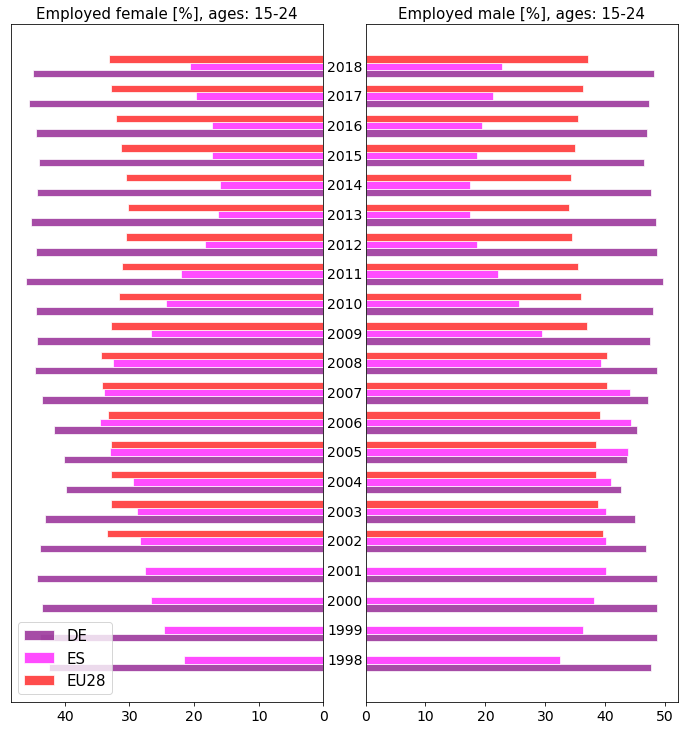

In [79]:
%run -i iipr-Master-Data-Science-dlc_zenodo_integration-1740440/make_plots.py lfsq_ergaed.tsv DE ES EU28 Y15-24 TOTAL

# Publicación de los Datos

Utilizando la API de Zenodo

¿Puedes replicar ese workflow en un sólo bloque con otros datos?